In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model

In [96]:
train = pd.read_csv('../demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [97]:
test = pd.read_csv('../demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


# Simple EDA

In [5]:
train['store'].unique

<bound method Series.unique of 0          1
1          1
2          1
3          1
4          1
          ..
912995    10
912996    10
912997    10
912998    10
912999    10
Name: store, Length: 913000, dtype: int64>

In [8]:
train[["store"]].nunique() 

store    10
dtype: int64

In [9]:
train[["item"]].nunique() 

item    50
dtype: int64

In [10]:
train.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]}) 

sales                             
               sum       mean median        std
store item                                     
1     1      36468  19.971522   19.0   6.741022
      2      97050  53.148959   52.0  15.005779
      3      60638  33.208105   33.0  10.072529
      4      36440  19.956188   20.0   6.640618
      5      30335  16.612815   16.0   5.672102
...            ...        ...    ...        ...
10    46    120601  66.046550   65.0  18.114991
      47     45204  24.755750   24.0   7.924820
      48    105570  57.814896   57.0  15.898538
      49     60317  33.032311   32.0  10.091610
      50    135192  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [11]:
# Extract year, month, day, and day of the week from the "date" column
# train['year'] = train['date'].dt.year
# train['month'] = train['date'].dt.month
# train['day'] = train['date'].dt.day
# train['dayofweek'] = train['date'].dt.dayofweek

# test['year'] = test['date'].dt.year
# test['month'] = test['date'].dt.month
# test['day'] = test['date'].dt.day
# test['dayofweek'] = test['date'].dt.dayofweek

In [12]:
# Group the data by store, item, and date, and calculate the mean sales
# train = train.groupby(['store', 'item', 'date']).mean().reset_index()

In [13]:
# train.set_index('date')

,store,item,sales,year,month,day,dayofweek
date,,,,,,,
2013-01-01,1,1,13.0,2013.0,1.0,1.0,1.0
2013-01-02,1,1,11.0,2013.0,1.0,2.0,2.0
2013-01-03,1,1,14.0,2013.0,1.0,3.0,3.0
2013-01-04,1,1,13.0,2013.0,1.0,4.0,4.0
2013-01-05,1,1,10.0,2013.0,1.0,5.0,5.0
...,...,...,...,...,...,...,...
2017-12-27,10,50,63.0,2017.0,12.0,27.0,2.0
2017-12-28,10,50,59.0,2017.0,12.0,28.0,3.0
2017-12-29,10,50,74.0,2017.0,12.0,29.0,4.0


In [18]:
# train = train.drop(['date'], axis=1)

In [19]:
# train

,store,item,sales,year,month,day,dayofweek
0,1,1,13.0,2013.0,1.0,1.0,1.0
1,1,1,11.0,2013.0,1.0,2.0,2.0
2,1,1,14.0,2013.0,1.0,3.0,3.0
3,1,1,13.0,2013.0,1.0,4.0,4.0
4,1,1,10.0,2013.0,1.0,5.0,5.0
...,...,...,...,...,...,...,...
912995,10,50,63.0,2017.0,12.0,27.0,2.0
912996,10,50,59.0,2017.0,12.0,28.0,3.0
912997,10,50,74.0,2017.0,12.0,29.0,4.0
912998,10,50,62.0,2017.0,12.0,30.0,5.0


In [21]:
# test = test.drop(['id', 'date'], axis=1)

In [22]:
# test

,store,item,year,month,day,dayofweek
0,1,1,2018,1,1,0
1,1,1,2018,1,2,1
2,1,1,2018,1,3,2
3,1,1,2018,1,4,3
4,1,1,2018,1,5,4
...,...,...,...,...,...,...
44995,10,50,2018,3,27,1
44996,10,50,2018,3,28,2
44997,10,50,2018,3,29,3
44998,10,50,2018,3,30,4


# Feature Engineering

In [98]:
df = pd.concat([train, test], axis=0)

In [99]:
df.drop('id', axis=1)

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0
...,...,...,...,...
44995,2018-03-27,10,50,NaN
44996,2018-03-28,10,50,NaN
44997,2018-03-29,10,50,NaN
44998,2018-03-30,10,50,NaN


In [100]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

In [101]:
df = df.reset_index()

In [102]:
df

,index,date,store,item,sales,id,year,month,day,dayofweek
0,0,2013-01-01,1,1,13.0,NaN,2013,1,1,1
1,1,2013-01-02,1,1,11.0,NaN,2013,1,2,2
2,2,2013-01-03,1,1,14.0,NaN,2013,1,3,3
3,3,2013-01-04,1,1,13.0,NaN,2013,1,4,4
4,4,2013-01-05,1,1,10.0,NaN,2013,1,5,5
...,...,...,...,...,...,...,...,...,...,...
957995,44995,2018-03-27,10,50,NaN,44995.0,2018,3,27,1
957996,44996,2018-03-28,10,50,NaN,44996.0,2018,3,28,2
957997,44997,2018-03-29,10,50,NaN,44997.0,2018,3,29,3
957998,44998,2018-03-30,10,50,NaN,44998.0,2018,3,30,4


In [103]:
df = df.fillna(0)

In [104]:
df = df.drop(['id','date','index'], axis=1)

In [105]:
df

,store,item,sales,year,month,day,dayofweek
0,1,1,13.0,2013,1,1,1
1,1,1,11.0,2013,1,2,2
2,1,1,14.0,2013,1,3,3
3,1,1,13.0,2013,1,4,4
4,1,1,10.0,2013,1,5,5
...,...,...,...,...,...,...,...
957995,10,50,0.0,2018,3,27,1
957996,10,50,0.0,2018,3,28,2
957997,10,50,0.0,2018,3,29,3
957998,10,50,0.0,2018,3,30,4


In [106]:
training = df[:-45000]

In [107]:
training

,store,item,sales,year,month,day,dayofweek
0,1,1,13.0,2013,1,1,1
1,1,1,11.0,2013,1,2,2
2,1,1,14.0,2013,1,3,3
3,1,1,13.0,2013,1,4,4
4,1,1,10.0,2013,1,5,5
...,...,...,...,...,...,...,...
912995,10,50,63.0,2017,12,27,2
912996,10,50,59.0,2017,12,28,3
912997,10,50,74.0,2017,12,29,4
912998,10,50,62.0,2017,12,30,5


In [108]:
testing = df[-45000:]

In [109]:
testing

,store,item,sales,year,month,day,dayofweek
913000,1,1,0.0,2018,1,1,0
913001,1,1,0.0,2018,1,2,1
913002,1,1,0.0,2018,1,3,2
913003,1,1,0.0,2018,1,4,3
913004,1,1,0.0,2018,1,5,4
...,...,...,...,...,...,...,...
957995,10,50,0.0,2018,3,27,1
957996,10,50,0.0,2018,3,28,2
957997,10,50,0.0,2018,3,29,3
957998,10,50,0.0,2018,3,30,4


### Implement shifting for time series prediction

In [110]:
def df_to_X_y(df, window_size=90, target_col=-1):
  df_as_np = df.to_numpy()
  num_features = df_as_np.shape[1] - 1  # number of input features
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = []
    for j in range(num_features):
      feature_data = df_as_np[i:i+window_size, j]
      row.append(feature_data.reshape((-1, 1)))
    X.append(row)
    label = df_as_np[i+window_size, target_col]
    y.append(label)
  return np.array(X), np.array(y)

In [111]:
# 90 days used to predict the 3 month period for test set
WINDOW_SIZE = 90
X, y = df_to_X_y(df, WINDOW_SIZE, target_col=2)

In [112]:
X.shape, y.shape

((957910, 6, 90, 1), (957910,))

In [121]:
train_size = int(len(training) * 0.8)
val_size = int(len(training) * 0.2)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size+train_size], y[train_size:val_size+train_size]
X_test, y_test = X[-len(test):], y[-len(test):]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

730400
182600


((730400, 6, 90, 1),
 (730400,),
 (182600, 6, 90, 1),
 (182600,),
 (45000, 6, 90, 1),
 (45000,))

In [122]:
model1 = Sequential()
model1.add(InputLayer((6, 90, 1)))
model1.add(Reshape((6, 90)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 6, 90)             0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                39680     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40,209
Trainable params: 40,209
Non-trainable params: 0
_________________________________________________________________


In [123]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [124]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
22824/22825 [============================>.] - ETA: 0s - loss: 609.1390 - root_mean_squared_error: 24.6807

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


22825/22825 [==============================] - 107s 5ms/step - loss: 609.1180 - root_mean_squared_error: 24.6803 - val_loss: 123.0840 - val_root_mean_squared_error: 11.0943
Epoch 2/10
22819/22825 [============================>.] - ETA: 0s - loss: 130.9557 - root_mean_squared_error: 11.4436

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


22825/22825 [==============================] - 94s 4ms/step - loss: 130.9540 - root_mean_squared_error: 11.4435 - val_loss: 109.4651 - val_root_mean_squared_error: 10.4626
Epoch 3/10
22810/22825 [============================>.] - ETA: 0s - loss: 110.6840 - root_mean_squared_error: 10.5206

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


22825/22825 [==============================] - 87s 4ms/step - loss: 110.6865 - root_mean_squared_error: 10.5208 - val_loss: 81.8805 - val_root_mean_squared_error: 9.0488
Epoch 4/10
22812/22825 [============================>.] - ETA: 0s - loss: 101.6177 - root_mean_squared_error: 10.0806

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


22825/22825 [==============================] - 88s 4ms/step - loss: 101.6071 - root_mean_squared_error: 10.0800 - val_loss: 81.1696 - val_root_mean_squared_error: 9.0094
Epoch 5/10
22825/22825 [==============================] - 79s 3ms/step - loss: 97.7918 - root_mean_squared_error: 9.8890 - val_loss: 82.0809 - val_root_mean_squared_error: 9.0599
Epoch 6/10
22812/22825 [============================>.] - ETA: 0s - loss: 94.3617 - root_mean_squared_error: 9.7140

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


22825/22825 [==============================] - 82s 4ms/step - loss: 94.3551 - root_mean_squared_error: 9.7137 - val_loss: 74.6230 - val_root_mean_squared_error: 8.6385
Epoch 7/10
22825/22825 [==============================] - 123s 5ms/step - loss: 89.5418 - root_mean_squared_error: 9.4627 - val_loss: 97.0913 - val_root_mean_squared_error: 9.8535
Epoch 8/10
22823/22825 [============================>.] - ETA: 0s - loss: 86.5139 - root_mean_squared_error: 9.3013

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


22825/22825 [==============================] - 127s 6ms/step - loss: 86.5144 - root_mean_squared_error: 9.3013 - val_loss: 72.7020 - val_root_mean_squared_error: 8.5265
Epoch 9/10
22822/22825 [============================>.] - ETA: 0s - loss: 83.5505 - root_mean_squared_error: 9.1406

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


22825/22825 [==============================] - 126s 6ms/step - loss: 83.5477 - root_mean_squared_error: 9.1404 - val_loss: 71.3552 - val_root_mean_squared_error: 8.4472
Epoch 10/10
22816/22825 [============================>.] - ETA: 0s - loss: 81.4523 - root_mean_squared_error: 9.0251

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


22825/22825 [==============================] - 123s 5ms/step - loss: 81.4555 - root_mean_squared_error: 9.0253 - val_loss: 71.3127 - val_root_mean_squared_error: 8.4447


In [125]:
model1 = load_model('model1/')

### Predictions on train

In [126]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

22825/22825 [==============================] - 54s 2ms/step


,Train Predictions,Actuals
0,14.463911,11.0
1,13.281942,19.0
2,16.612482,24.0
3,14.730852,18.0
4,17.388006,19.0
...,...,...
730395,16.243830,12.0
730396,18.234699,20.0
730397,21.637053,22.0
730398,13.224737,14.0


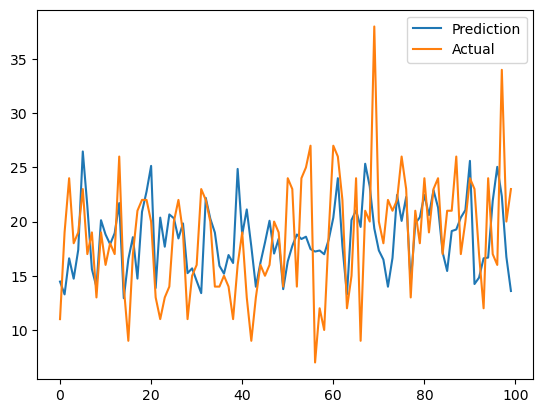

In [127]:
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])

plt.legend(['Prediction', 'Actual'])

### Predictions on val

In [128]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

5707/5707 [==============================] - 14s 2ms/step


,Val Predictions,Actuals
0,15.271429,19.0
1,19.320179,12.0
2,23.612320,18.0
3,21.316847,13.0
4,21.602625,25.0
...,...,...
182595,17.468977,0.0
182596,15.144625,0.0
182597,13.593357,0.0
182598,16.600166,0.0


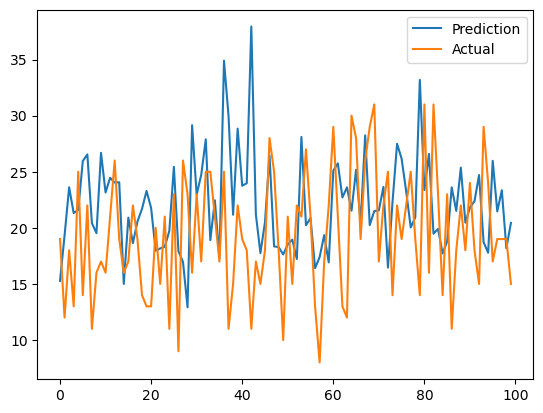

In [129]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

plt.legend(['Prediction', 'Actual'])

### Predictions on test

In [136]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Sales':test_predictions})
test_results

1407/1407 [==============================] - 3s 2ms/step


,Sales
0,51.114868
1,57.225933
2,63.879101
3,57.116566
4,70.459808
...,...
44995,44.010891
44996,45.530655
44997,43.542896
44998,44.897678


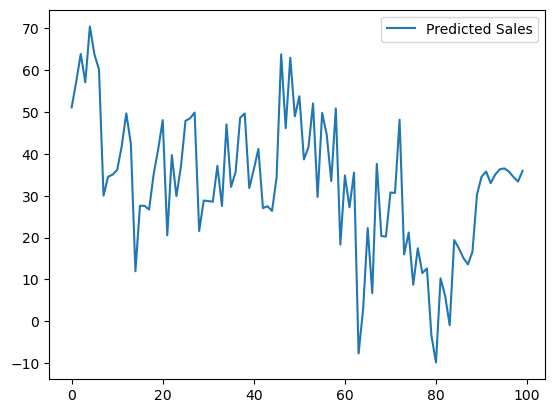

In [139]:
plt.plot(test_results['Sales'][:100])

plt.legend(['Predicted Sales'])

In [141]:
test_results = test_results.rename_axis('id')

In [142]:
test_results

,Sales
id,
0,51.114868
1,57.225933
2,63.879101
3,57.116566
4,70.459808
...,...
44995,44.010891
44996,45.530655
44997,43.542896


In [143]:
test_results.to_csv('deeplearning_submission.csv', index=True)